In [1]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes

In [2]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-a9zoahdp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-a9zoahdp
  Resolved https://github.com/huggingface/transformers to commit a830df2909f672b23d7e30e1a8c2ed67f6404e54
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -q peft  accelerate bitsandbytes safetensors

In [4]:
!pip install sentencepiece


In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import transformers

model_name = "filipealmeida/Mistral-7B-Instruct-v0.1-sharded"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # load_in_4bit=True,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.bos_token_id = 1
# stop_token_ids = [0]

# Ensure the tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding token

print(f"Successfully loaded the model {model_name} into memory")



RuntimeError: Failed to import transformers.models.auto because of the following error (look up to see its traceback):
cannot import name '_sentencepiece' from partially initialized module 'sentencepiece' (most likely due to a circular import) (D:\anaconda3\lib\site-packages\sentencepiece\__init__.py)

In [21]:
import pandas as pd

# Load
file_path = 'QA_pair.xlsx'
data = pd.read_excel(file_path)

# Preview the data
print(data.head())


                                            Question  \
0                What is the title of this course?     
1            Who is the instructor of this course?     
2  In which semester is this course being offered?     
3                      When are the lectures held?     
4                     Where are the lectures held?     

                                              Answer  
0  ESE 577 — Deep Learning: Algorithms and Software.  
1                               Jorge Mendez-Mendez.  
2            It’s offered in the Fall 2024 semester.  
3  The lectures are held on Thursdays, from 6:30 ...  
4            The lectures are held in Frey Hall 216.  


In [22]:
# Function to generate model output for each row
def generate_output(row):
    # Extract the question text from the row
    question_text = row['Question']  # or row['Question'] if your DataFrame has a column named 'Question'

    # Create an input prompt for the model
    prompt = f"[INST] {question_text}[INST] "

    # Tokenize the prompt
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)

    # Generate output
    generated_ids = model.generate(
        **encoded_input,
        max_new_tokens=100,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id  # Set pad_token_id to eos_token_id
    )
    
    # Move input tensors to the same device as the model (GPU[0] or CPU)
    encoded_input = {key: value.to(model.device) for key, value in encoded_input.items()}

    # Decode the generated output
    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_output[0]

# Apply the function to each row in the DataFrame
for index, row in data.iterrows():
    output = generate_output(row)
    print(f"Output for row {index}:\n{output}\n")


Output for row 0:
[INST] What is the title of this course?  [INST] 1. "Introduction to Programming Concepts using Python"

Output for row 1:
[INST] Who is the instructor of this course?  [INST] 🤖 I'm sorry, but I do not know who the instructor of this course is. Can you please provide me more context or details about the course so that I can assist you better?

Output for row 2:
[INST] In which semester is this course being offered?  [INST]  I don't have real-time data. The course offeringsvaries based on the university and year. Please check with your university's course catalog or their website for the most up-to-date information.

Output for row 3:
[INST] When are the lectures held?  [INST] 9:00 AM - 10:55 AM on Mondays and Wednesdays

Output for row 4:
[INST] Where are the lectures held?  [INST] 42nd Street, between 7th and 9th avenues.

Output for row 5:
[INST] Is attendance mandatory for the lectures?  [INST] 1. Check the syllabus: The syllabus may state whether attendance is man

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Successfully loaded the model filipealmeida/Mistral-7B-Instruct-v0.1-sharded into memory


Epoch,Training Loss,Validation Loss
1,1.436700,2.378801
2,1.302700,2.340191
3,1.286000,2.312865
4,1.271000,2.284784
5,1.256400,2.255839
6,1.242200,2.226536
7,1.228400,2.203182
8,1.215900,2.185507
9,1.203500,2.166203
10,1.191800,2.148781


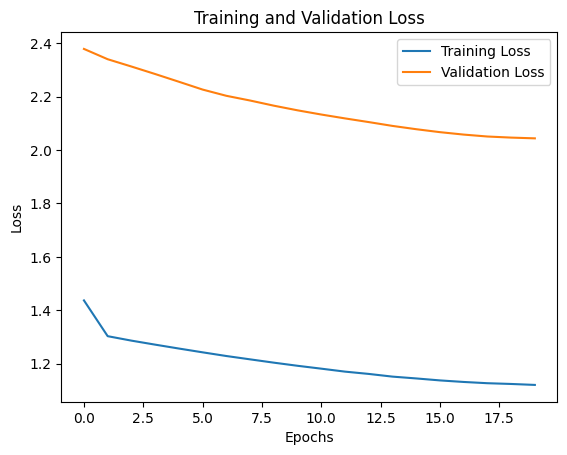

In [23]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from peft import get_peft_model, LoraConfig, TaskType
from transformers import DataCollatorForSeq2Seq
import transformers
import matplotlib.pyplot as plt
import warnings
import os

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the Mistral-7B model and tokenizer
model_name = "filipealmeida/Mistral-7B-Instruct-v0.1-sharded"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # load_in_4bit=True,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ensure the tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding token

print(f"Successfully loaded the model {model_name} into memory")


# Configure adapters using PEFT (Low-Rank Adapters in this case)
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank adapter
    lora_alpha=32,  # Scaling factor for LoRA weights
    target_modules=["q_proj", "v_proj"],  # Specify which modules to apply LoRA to
    lora_dropout=0.1,  # Dropout probability
    task_type=TaskType.CAUSAL_LM,  # Task type for causal language modeling
)

# Attach LoRA adapters to the quantized model
model = get_peft_model(model, lora_config)

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=100):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        prompt = self.data.iloc[idx]['Question']
        response = self.data.iloc[idx]['Answer']
        
        # Tokenize the input and output pair (question and answer)
        input_encoding = self.tokenizer(prompt, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        output_encoding = self.tokenizer(response, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        
        # Ensure to squeeze the tensors to remove unnecessary dimensions
        input_ids = input_encoding['input_ids'].squeeze()
        attention_mask = input_encoding['attention_mask'].squeeze()
        labels = output_encoding['input_ids'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Load the dataset (replace with your actual file path)
file_path = 'QA_pair.xlsx'
data = pd.read_excel(file_path)

# Split the data into train and eval datasets
train_data, eval_data = train_test_split(data, test_size=0.2)

# Create CustomDataset instances
train_dataset = CustomDataset(train_data, tokenizer)
eval_dataset = CustomDataset(eval_data, tokenizer)

# Create a data collator to handle dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",            # Output directory for results
    num_train_epochs=20,               # Number of epochs to train
    per_device_train_batch_size=2,     # Batch size per device during training
    gradient_accumulation_steps=16,    # Gradient accumulation steps to simulate a larger batch size
    logging_dir='./logs',              # Directory to save logs
    logging_steps=1,                  # Log every 50 steps
    save_strategy="epoch",             # Save model at the end of each epoch
    save_total_limit=2,                # Keep only the 2 most recent checkpoints
    fp16=True,                         # Use mixed precision training
    evaluation_strategy="epoch",       # Evaluate at the end of every epoch
    load_best_model_at_end=True,       # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Metric to track for best model
    greater_is_better=False,           # Lower eval_loss is better, so set this to False
)

# Custom Trainer to track losses
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_losses = []
        self.eval_losses = []

    def log(self, logs, start_time=None):
        # Save the training loss
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        # Save the eval loss (if available)
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])
        super().log(logs)

# Initialize the CustomTrainer
trainer = CustomTrainer(
    model=model,                        # The model to train
    args=training_args,                 # Training arguments
    train_dataset=train_dataset,        # The train dataset
    eval_dataset=eval_dataset,          # The eval dataset for evaluation during training
    tokenizer=tokenizer,                # Tokenizer for preprocessing
    data_collator=data_collator,        # Custom data collator for padding
)

# Start training
trainer.train()

# Plot the training and validation loss
plt.plot(trainer.train_losses, label='Training Loss')
plt.plot(trainer.eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Save the best model (the one with the smallest validation loss)
best_model_dir = "./best_model"
os.makedirs(best_model_dir, exist_ok=True)

# Save the best model (the one with the smallest validation loss)
trainer.save_model(best_model_dir)



In [25]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import os

# Path to the saved best model directory
best_model_dir = "./best_model"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    best_model_dir,
    # load_in_4bit=True,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

# Ensure the tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding token

print(f"Successfully loaded the model {best_model_dir} into memory")

# # Path to the saved best model directory
# best_model_dir = "./best_model"

# # Load the saved model and tokenizer
# model = AutoModelForCausalLM.from_pretrained(best_model_dir, torch_dtype=torch.bfloat16)
# tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

# Move the model to GPU[0] for inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Function to generate model output for each row
def generate_output(row):
    # Extract the question text from the row
    question_text = row['Question']  # or row['Question'] if your DataFrame has a column named 'Question'

    # Create an input prompt for the model
    prompt = f"[INST] {question_text}[INST] "

    # Tokenize the prompt
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)

    # Move the input tensors to GPU[0]
    encoded_input = {key: value.to(device) for key, value in encoded_input.items()}

    # Generate output
    generated_ids = model.generate(
        **encoded_input,
        max_new_tokens=100,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id  # Set pad_token_id to eos_token_id
    )

    # Decode the generated output
    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_output[0]

# Load your dataset (replace with your actual file path)
file_path = 'QA_pair.xlsx'  # Update with your actual file path
data = pd.read_excel(file_path)

# Apply the function to each row in the DataFrame and generate the output
for index, row in data.iterrows():
    output = generate_output(row)
    print(f"Output for row {index}:\n{output}\n")

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]
You shouldn't move a model that is dispatched using accelerate hooks.


Successfully loaded the model ./best_model into memory
cuda:0
Output for row 0:
[INST] What is the title of this course?  [INST] 101 Introduction to Artificial Intelligence

Output for row 1:
[INST] Who is the instructor of this course?  [INST] ¡Hola! I am an AI language model, and I don't have the ability to provide current information. Could you please specify which course you are referring to so I can provide a more helpful answer?

Output for row 2:
[INST] In which semester is this course being offered?  [INST] 4

Output for row 3:
[INST] When are the lectures held?  [INST] 6th - 10th October 2021 -

Output for row 4:
[INST] Where are the lectures held?  [INST] 1. The lectures are held in the Auditorium.

Output for row 5:
[INST] Is attendance mandatory for the lectures?  [INST] 1. It says "you must attend all six presentations" in the syllabus.
2. The syllabus also states "Attendance: Attendance is mandatory for all the lectures. Students should attend 70% lectures compulsory."
3.

KeyboardInterrupt: 